In [1]:
from large_gcs.algorithms.gcs_star import GcsAstarReachability
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.graph.cost_constraint_factory import (
    shortcut_edge_cost_factory,
)
from large_gcs.algorithms.search_algorithm import SearchNode
from large_gcs.graph.graph import ShortestPathSolution
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
)

import numpy as np
from IPython.display import HTML

import logging

logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.DEBUG)
logging.getLogger(__name__).setLevel(logging.DEBUG)
logger = logging.getLogger(__name__)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 43240.25it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 20360.70it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 182.24it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (100)
100%|██████████| 100/100 [00:00<00:00, 4844.15it/s]


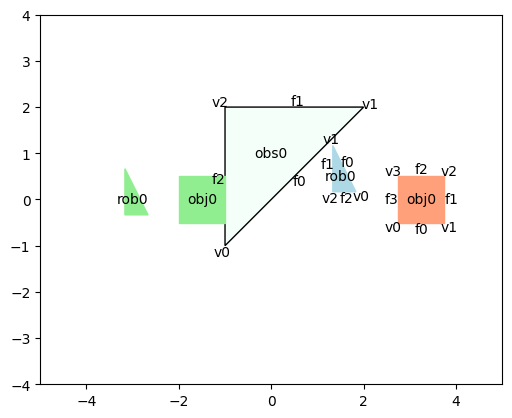

In [2]:
graph_file = ContactGraphGeneratorParams.inc_graph_file_path_from_name("cg_trichal2")
cg = IncrementalContactGraph.load_from_file(
    graph_file,
    should_incl_simul_mode_switches=False,
    should_add_const_edge_cost=True,
    should_add_gcs=True,
)
cg.plot()

In [3]:
vertex_path = [
    "source",
    "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')",
    "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_v0-rob0_f0')",
    "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f3-rob0_v0')",
    "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f2-rob0_f2')",
]

for v in vertex_path[1:]:
    cg.generate_successors(v)

# cg.generate_and_plot_samples_in_set(vertex_path[-1], 20)

In [4]:
edge_path = []
for i in range(len(vertex_path) - 1):
    edge_path.append(f"{str((vertex_path[i], vertex_path[i + 1]))}")
edge_path

['(\'source\', "(\'NC|obs0_f0-obj0_v3\', \'NC|obs0_f0-rob0_v1\', \'NC|obj0_f3-rob0_v0\')")',
 '("(\'NC|obs0_f0-obj0_v3\', \'NC|obs0_f0-rob0_v1\', \'NC|obj0_f3-rob0_v0\')", "(\'NC|obs0_f0-obj0_v3\', \'NC|obs0_f0-rob0_v1\', \'IC|obj0_v0-rob0_f0\')")',
 '("(\'NC|obs0_f0-obj0_v3\', \'NC|obs0_f0-rob0_v1\', \'IC|obj0_v0-rob0_f0\')", "(\'NC|obs0_f0-obj0_v3\', \'NC|obs0_f0-rob0_v1\', \'IC|obj0_f3-rob0_v0\')")',
 '("(\'NC|obs0_f0-obj0_v3\', \'NC|obs0_f0-rob0_v1\', \'IC|obj0_f3-rob0_v0\')", "(\'NC|obs0_f0-obj0_v3\', \'NC|obs0_f0-rob0_v1\', \'NC|obj0_f2-rob0_f2\')")']

In [5]:
# Add the problematic sample to the graph

from large_gcs.geometry.point import Point
from large_gcs.graph.graph import Edge, Vertex


proj_sample = [
    3.25000000e00,
    3.25000000e00,
    -6.82246748e-09,
    -6.82246748e-09,
    2.41668222e00,
    2.29658427e00,
    8.33324114e-01,
    8.33324433e-01,
    -0.00000000e00,
    -0.00000000e00,
    -1.20097952e-01,
    3.18708507e-07,
    -1.20097952e-01,
    3.18708507e-07,
]

# Create a new vertex for the sample and add it to the graph
sample_vertex_name = f"{vertex_path[-1]}_sample_{0}"

cg.add_vertex(vertex=Vertex(convex_set=Point(proj_sample)), name=sample_vertex_name)

# Calculate the cost to come to the sample for the candidate path
e = cg.edges[edge_path[-1]]
edge_to_sample = Edge(
    u=e.u,
    v=sample_vertex_name,
    costs=e.costs,
    constraints=e.constraints,
)
cg.add_edge(edge_to_sample)
cg.set_target(sample_vertex_name)
active_edges = edge_path.copy()
active_edges[-1] = edge_to_sample.key

In [6]:
from pydrake.all import SolverOptions, MosekSolver, CommonSolverOption

solver_options = SolverOptions()
# solver_options.SetOption(MosekSolver().solver_id(), "MSK_DPAR_BASIS_REL_TOL_S", 1e-6)
# solver_options.SetOption(MosekSolver().solver_id(), "MSK_DPAR_BASIS_TOL_S", 1e-3)
# solver_options.SetOption(MosekSolver().solver_id(), "MSK_DPAR_BASIS_TOL_X", 1e-3)
# solver_options.SetOption(MosekSolver().solver_id(), "MSK_DPAR_INTPNT_TOL_PFEAS", 1e-2)
# solver_options.SetOption(MosekSolver().solver_id(), "MSK_DPAR_INTPNT_TOL_INFEAS", 1e-2)
solver_options.SetOption(
    MosekSolver().solver_id(), "MSK_DPAR_INTPNT_CO_TOL_INFEAS", 1e-2
)
solver_options.SetOption(
    MosekSolver().solver_id(), "MSK_DPAR_INTPNT_CO_TOL_PFEAS", 1e-15
)
# solver_options.SetOption(MosekSolver().solver_id(), "MSK_DPAR_INTPNT_CO_TOL_NEAR_REL", 1e5)
solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)

In [7]:
sol = cg.solve_convex_restriction(
    active_edges, skip_post_solve=True, solver_options=solver_options
)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 232             
  Affine conic cons.     : 3 (15 rows)
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 65              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 0                 time                   : 0.00            
Lin. dep.  - primal attempts        : 0                 successes              : 0               
Lin. dep.  - dual attempts          : 0                 successes              : 0               
Lin. dep.  - primal deps.           : 0                 dual deps.             : 0               
Presolve te

In [8]:
sol.is_success

False

In [9]:
sol.result.get_solver_details()

In [14]:
sol.result.GetInfeasibleConstraints()

TypeError: GetInfeasibleConstraints(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.solvers.MathematicalProgramResult, prog: drake::solvers::MathematicalProgram, tol: Optional[float] = None) -> List[pydrake.solvers.Binding𝓣Constraint𝓤]

Invoked with: <pydrake.solvers.MathematicalProgramResult object at 0x70c634c46770>

In [10]:
terminal_set = cg.vertices[vertex_path[-1]].convex_set.set

In [11]:
terminal_set.PointInSet(proj_sample, tol=0)

False

In [12]:
terminal_set.PointInSet(proj_sample)

True